# Implementing a GPT model from Scratch To Generate Text 

This lab covers
- Coding a GPT-like large language model (LLM) that can be trained to generate human-like text
- Normalizing layer activations to stabilize neural network training
- Adding shortcut connections in deep neural networks to train models more effectively
- Implementing transformer blocks to create GPT models of various sizes
- Computing the number of parameters and storage requirements of GPT models

In [1]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.2
torch version: 2.0.1
tiktoken version: 0.7.0


- In this lab, we implement a GPT-like LLM architecture; the next lab will focus on training this LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="700px">

## 1 Coding an LLM architecture

- GPT and Llama generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code
- However, despite model size, the model architecture is not complicated, since many of its components are repeated.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="600px">

- In previous labs, we used small embedding dimensions for token inputs and outputs for ease of illustration
- In this lab, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)

- In the context of deep learning and LLMs like GPT, the term ``parameters`` refers to the trainable weights of the model. 
- These weights are essentially the internal variables of the model that are adjusted and optimized
during the training process to minimize a specific loss function. This optimization allows the model to learn from the training data.

- For example, in a neural network layer that is represented by a 2,048x2,048- dimensional matrix (or tensor) of weights, each element of this matrix is a parameter. Since there are 2,048 rows and 2,048 columns, the total number of
parameters in this layer is 2,048 multiplied by 2,048, which equals 4,194,304
parameters.

- Configuration details for the 124 million parameter GPT-2 model include:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in lab 1
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in lab 1
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in lab 2
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections
- `"drop_rate"` is the dropout mechanism's intensity, discussed in lab 2; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism (from lab 2) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation

- Using the configuration above, we will start by implementing a GPT placeholder architecture (`DummyGPTModel`) in this section, as shown in the figure below. 
- This will provide us with a big-picture view of how everything fits together and what other components we need to code in the upcoming
sections to assemble the full GPT model architecture.

- We will start with step 1, a placeholder GPT backbone we call `DummyGPTModel`:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="700px">

- The `DummyGPTModel` class defines a simplified version of a GPT-like model using PyTorch's neural network module (nn.Module). 
- The model architecture consists of token and positional embeddings, dropout, a series of transformer blocks (`DummyTransformerBlock`), a final layer normalization (`DummyLayerNorm`), and a linear output layer (out_head). 
- The configuration is passed in via a Python dictionary, for instance, the `GPT_CONFIG_124M` dictionary we created earlier.

- The `forward` method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout,
processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.

- For now, we have used placeholders (`DummyLayerNorm` and `DummyTransformerBlock`) for the transformer block and layer normalization, which we will develop in later
sections.

In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

- Next, we will prepare the input data and initialize a new GPT model to illustrate its usage

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="700px">

- We tokenize a batch consisting
of two text inputs for the GPT model using the tiktoken tokenizer introduced
in lab 1 and print the resulting token IDs.

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


- Next, we initialize a new 124 million parameter ``DummyGPTModel`` instance and
feed it the tokenized batch


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


- The model outputs are commonly referred to as logits
- The output tensor has two rows corresponding to the two text samples. Each
text sample consists of 4 tokens; each token is a 50,257-dimensional vector,
which matches the size of the tokenizer's vocabulary

## 2 Normalizing activations with layer normalization

- Training deep neural networks with many layers can sometimes prove
challenging due to issues like vanishing or exploding gradients. These issues
lead to unstable training dynamics and make it difficult for the network to
effectively adjust its weights, which means the learning process struggles to
find a set of parameters (weights) for the neural network that minimizes the
loss function.
- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

- Let's see how layer normalization works by passing a small input sample through a simple neural network layer, recreating the example shown in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="600px">

- We implement a neural network layer with 5 inputs and 6 outputs that
we apply to two input examples.
- The neural network layer consists of a Linear layer followed
by a non-linear activation function, ReLU,
which is a standard activation function in neural networks.

In [6]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- The output is a tensor, where the first row lists the layer outputs for
the first input and the second row lists the layer outputs for the second row

- Let's compute the mean and variance for each of the 2 inputs above:

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The first row in the mean tensor above contains the mean value for the first
input row, and the second output row contains the mean for the second input
row.
- Using ``keepdim=True`` in ``mean`` or ``variance`` calculation ensures
that the output tensor retains the same shape as the input tensor, even though
the operation reduces the tensor along the dimension specified via dim. For
instance, without ``keepdim=True``, the returned mean tensor would be a 2-
dimensional vector ``[0.1324, 0.2170]`` instead of a 2×1-dimensional matrix
``[[0.1324], [0.2170]]``.
- The ``dim`` parameter specifies the dimension along which the calculation of the
statistic (here, mean or variance) should be performed in a tensor

- The normalization is applied to each of the two inputs (rows) independently; using ``dim=-1`` applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

- For a 2D tensor (like a matrix), using ``dim=-1`` for
operations such as mean or variance calculation is the same as using ``dim=1``

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="600px">

- Let's apply layer normalization to the layer outputs we obtained earlier.
- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- As we can see based on the results, the normalized layer outputs, which now
also contain negative values, have zero mean and a variance of 1

- To improve readability, we can disable PyTorch's scientific notation:

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Above, we normalized the features of each input
- Now, using the same idea, we can implement a `LayerNorm` class:

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance 
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`
 is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 3 Implementing a feed forward network with GELU activations

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="600px">

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

- We can implement this function as PyTorch module as follows:

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

- **Note:** If the code below is not working, and you are using torch version: 2.0.1, please downgrade your numpy version to 1.24.1

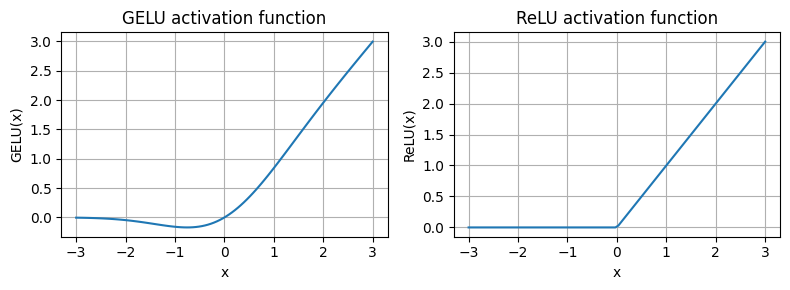

In [34]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)
- The smoothness of GELU, as shown in the figure above, can lead to better
optimization properties during training, as it allows for more nuanced
adjustments to the model's parameters. In contrast, ReLU has a sharp cornerat zero, which can sometimes make optimization harder, especially in
networks that are very deep or have complex architectures. 
- Moreover, unlike
RELU, which outputs zero for any negative input, GELU allows for a small,
non-zero output for negative values. This characteristic means that during the
training process, neurons that receive negative input can still contribute to the
learning process, albeit to a lesser extent than positive inputs.


- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later
- The ``FeedForward`` module is a small
neural network consisting of two Linear layers and a GELU activation
function. In the 124 million parameter GPT model, it receives the input
batches with tokens that have an embedding size of 768 each via the
``GPT_CONFIG_124M`` dictionary where ``GPT_CONFIG_124M["emb_dim"] = 768``.

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


- The figure below shows how the embedding size is manipulated inside this small
feed forward neural network when we pass it some inputs.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="600px">

- Following the example in the figure, let's initialize a new ``FeedForward``
module with a token embedding size of 768 and feed it a batch input with 2
samples and 3 tokens each:

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


- The ``FeedForward`` module we implemented in this section plays a crucial role
in enhancing the model's ability to learn from and generalize the data.
- Although the input and output dimensions of this module are the same, it
internally expands the embedding dimension into a higher-dimensional space
through the first linear layer as illustrated in figure below. 
- This expansion is
followed by a non-linear GELU activation, and then a contraction back to the
original dimension with the second linear transformation. 
- Such a design
allows for the exploration of a richer representation space.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="600px">

## 4 Adding shortcut connections

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="600px">

- Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
- Originally, **shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems**
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="600px">

- Let's implement a deep neural network with 5 layers, each consisting of
a ``Linear layer`` and a ``GELU activation function``. 
- In the forward pass, we
iteratively pass the input through the layers and optionally add the shortcut
connections depicted in the figure above if the ``self.use_shortcut`` attribute is set
to True.

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- We specified a loss function that computes how close the
model output and a user-specified target (here, for simplicity, the value 0)
are. Then, when calling ``loss.backward()``, PyTorch computes the loss
gradient for each layer in the model. We can iterate through the weight
parameters via ``model.named_parameters()``.
- The ``.backward()`` method is a convenient method in PyTorch that
computes loss gradients, which are required during model training, without
implementing the math for the gradient calculation ourselves, thereby making
working with deep neural networks much more accessible.

- Let's use the code to first initialize a neural network without shortcut
connections. Here, each layer will be initialized such that it accepts an
example with 3 input values and returns 3 output values. The last layer
returns a single output value
- Let's print the gradient values first **without** shortcut connections:

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- As we can see based on the output of the ``print_gradients`` function, the
gradients become smaller as we progress from the last layer (``layers.4``) to the
first layer (``layers.0``), which is a phenomenon called the **vanishing gradient**
problem.

- Next, let's print the gradient values **with** shortcut connections:

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263


- As we can see, based on the output, the last layer (``layers.4``) still has a larger
gradient than the other layers. However, the gradient value stabilizes as we
progress towards the first layer (``layers.0``) and doesn't shrink to a
vanishingly small value.
- Shortcut connections prevent the gradients from vanishing in the early layers
- We will use this concept of a shortcut connection next when we implement a transformer block

- In conclusion, shortcut connections are important for overcoming the
limitations posed by the vanishing gradient problem in deep neural networks.
- Shortcut connections are a core building block of very large models such as
LLMs, and they will help facilitate more effective training by ensuring
consistent gradient flow across layers when we train the GPT model.

## 5 Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

- When a transformer block processes an input sequence, each element in the
sequence (for example, a word or subword token) is represented by a fixed-
size vector (in our case, 768 dimensions). 
- The operations
within the transformer block, including multi-head attention and feed forward
layers, are designed to transform these vectors in a way that preserves their
dimensionality.

- The idea is that the self-attention mechanism in the multi-head attention
block identifies and analyzes relationships between elements in the input
sequence. 
- In contrast, the feed forward network modifies the data
individually at each position. 
- This combination not only enables a more
nuanced understanding and processing of the input but also enhances the
model's overall capacity for handling complex data patterns.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="600px">

- But first, let's define again the ``MultiHeadAttention`` class from lab 2

In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

- And now, let's define our `TransformerBlock` that uses `MultiHeadAttention` and a feed forward
network (``FeedForward``), both configured based on a provided configuration
dictionary (cfg), such as GPT_CONFIG_124M.

- Layer normalization (``LayerNorm``) is applied before each of these two
components, and dropout is applied after them to regularize the model and
prevent overfitting. This is also known as ``Pre-LayerNorm``. Older
architectures, such as the original transformer model, applied layer
normalization after the self-attention and feed-forward networks instead,
known as ``Post-LayerNor``m, which often leads to **worse** training dynamics.

- The class also implements the ``forward`` pass, where each component is
followed by a shortcut connection that adds the input of the block to its
output. This critical feature helps gradients flow through the network during
training and improves the learning of deep models

In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- The preservation of shape throughout the transformer block architecture is
not incidental but a crucial aspect of its design. This design enables its
effective application across a wide range of sequence-to-sequence tasks,
where each output vector directly corresponds to an input vector, maintaining
a one-to-one relationship. 
- The output is a context vector that
encapsulates information from the entire input sequence, as we learned in
lab 2. This means that while the physical dimensions of the sequence
(length and feature size) remain unchanged as it passes through the
transformer block, the content of each output vector is re-encoded to integrate
contextual information from across the entire input sequence.

In [23]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 6 Coding the GPT model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="600px">

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this lab so that we obtain a usable GPT architecture

- We are now replacing the ``DummyTransformerBlock`` and
``DummyLayerNorm`` placeholders with the real ``TransformerBlock`` and
``LayerNorm`` classes to assemble a fully working
version of the original 124 million parameter version of GPT-2. 


- Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="600px">

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

- Thanks to the ``TransformerBlock`` class we implemented earlier, the
``GPTModel`` class is relatively small and compact.


- The ``__init__`` constructor of this ``GPTModel`` class initializes the token and
positional embedding layers using the configurations passed in via a Python
dictionary, ``cfg``. These embedding layers are responsible for converting input
token indices into dense vectors and adding positional information.
- Next, the ``__init__`` method creates a sequential stack of ``TransformerBlock``
modules equal to the number of layers specified in cfg. Following the
transformer blocks, a ``LayerNorm`` layer is applied, standardizing the outputs
from the transformer blocks to stabilize the learning process.
- Finally, a linear
output head without bias is defined, which projects the transformer's output
into the vocabulary space of the tokenizer to generate logits for each token in
the vocabulary.

- The ``forward`` method takes a batch of input token indices, computes their
embeddings, applies the positional embeddings, passes the sequence through
the transformer blocks, normalizes the final output, and then computes the
logits, representing the next token's unnormalized probabilities. We will
convert these logits into tokens and text outputs in the next section.

In [24]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- As we can see, the output tensor has the shape ``[2, 4, 50257]``, since we
passed in 2 input texts with 4 tokens each. The last dimension, 50,257,
corresponds to the vocabulary size of the tokenizer. In the next section, we
will see how to convert each of these 50,257-dimensional output vectors back
into tokens.

- We will train this model in the next lab
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

Using the ``numel()`` method, short for "number of elements," we can collect
the total number of parameters in the model's parameter tensors:

In [26]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices

In [27]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [28]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, it is easier to train the model without weight-tying, which is why we didn't implement it here
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [29]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 7 Generating text

- LLMs like the GPT model we implemented above are used to generate one word at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="600px">

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- The figure below depicts how the GPT model, given an input context, generates the next word token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="800px">

- The process by which a GPT model goes from output tensors to generated
text involves several steps: decoding the output tensors, selecting tokens based on a probability
distribution, and converting these tokens into human-readable text.

- The next-token generation process detailed in the figure amove illustrates a single
step where the GPT model generates the next token given its input.
- In each step, the model outputs a matrix with vectors representing potential
next tokens. 
- The vector corresponding to the next token is extracted and
converted into a probability distribution via the softmax function. 
- Within the
vector containing the resulting probability scores, the index of the highest
value is located, which translates to the token ID. 
- This token ID is then
decoded back into text, producing the next token in the sequence. 
- Finally, this
token is appended to the previous inputs, forming a new input sequence for
the subsequent iteration. 
- This step-by-step process enables the model to
generate text sequentially, building coherent phrases and sentences from the
initial input context.
- In practice, we repeat this process over many iterations.

- We can implement the token-generation process as follows:

In [30]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- Above is a a simple implementation of a
generative loop for a language model using PyTorch. It iterates for a
specified number of new tokens to be generated, crops the current context to
fit the model's maximum context size, computes predictions and then selects
the next token based on the highest probability prediction.

- In the ``generate_text_simple function``, we use a
``softmax`` function to convert the logits into a probability distribution from
which we identify the position with the highest value via ``torch.argmax``. 
- The
``softmax`` function is monotonic, meaning it preserves the order of its inputs
when transformed into outputs. So, in practice, the ``softmax`` step is redundant
since the position with the highest score in the softmax output tensor is the
same position in the logit tensor. 
- In other words, we could apply the
``torch.argmax`` function to the logits tensor directly and get identical results.
However, we coded the conversion to illustrate the full process of
transforming logits to probabilities, which can add additional intuition, such
as that the model generates the most likely next token, which is known as
``greedy decoding``.
- In the next lab, when we will implement the GPT training code, **we will
also introduce additional sampling techniques where we modify the softmax
outputs such that the model doesn't always select the most likely token, which
introduces variability and creativity in the generated text**.

- This process of generating one token ID at a time and appending it to the
context using the generate_text_simple function is further illustrated below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- We generate the token IDs in an iterative fashion.
For instance, in iteration 1, the model is provided with the tokens
corresponding to "Hello , I am", predicts the next token (with ID 257, which
is "a"), and appends it to the input. This process is repeated until the model
produces the complete sentence "Hello, I am a model ready to help." after six
iterations.

- Let's now try out the ``generate_text_simple`` function with the "Hello, I
am" context as model input

- First, we encode the input context into token IDs:

In [31]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


- Next, we put the model into ``.eval()`` mode, which disables random
components like dropout, which are only used during training, and use the
``generate_text_simple`` function on the encoded input tensor:

In [32]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next lab